<a href="https://colab.research.google.com/github/Otavio8888/econometric_tests/blob/test5/EA06_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Econometria Aplicada [Módulo em Python]

### Outros problemas


## Introdução

Nesta seção iremos falar sobre alguns problemas em relação a estimação e análise da regressão linear. Iremos abordar diferentes especificações possíveis nas equações de regressão. Além disso mostraremos como podemos fazer previsão com uma regressão estimada.

In [ ]:
!pip install wooldridge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 16.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import wooldridge as woo
import matplotlib.pyplot as plt


## Diferentes especificações

### Escala dos dados

A escala das variáveis impacta no valor do parâmetro estimado. Por exemplo, se estivermos interessados em algum problema que a variável dependente está em peso, colocar o peso em gramas, kilos ou toneladas afetará o valor do parâmetro. Podemos mostrar um exemplo disso com o dataset "bwght", traz um estudo do efeito do uso de cigarros por gestantes no peso do bebe.

Primeiramente, iremos estimar a seguinte regressão:

\begin{equation}
\text { bwght }=\beta_{0}+\beta_{1} \text { cigs }+\beta_{2} \text { faminc }+u
\end{equation}

Em que o peso do bebe (bwght) está em onças. As outras duas variáveis são o número de cigarros por dia (cigs) e a renda familiar (faminc), em milhares de dólares.

Após isso, vamos comparar com os parâmetros estimados utilizando o peso em kilogramas e em número de carteiras de cigarro por dia (cada carteira tem 20 cigarros).

In [ ]:
bwght = woo.dataWoo('bwght')

# Peso em onças
reg = smf.ols(formula='bwght ~ cigs + faminc', data=bwght)
results = reg.fit()

# Peso em kg
reg_kg = smf.ols(formula='I(bwght/35.274) ~ cigs + faminc', data=bwght)
results_kg = reg_kg.fit()

# carteira de cigarros
reg_packs = smf.ols(formula='bwght ~ I(cigs/20) + faminc', data=bwght)
results_packs = reg_packs.fit()

table = pd.DataFrame({'b': round(results.params, 4),
                      'b_kg': round(results_kg.params, 4),
                      'b_packs': round(results_packs.params, 4)})
table

,b,b_kg,b_packs
I(cigs / 20),NaN,NaN,-9.2682
Intercept,116.9741,3.3162,116.9741
cigs,-0.4634,-0.0131,NaN
faminc,0.0928,0.0026,0.0928


Como é possível perceber, dividir a variável dependente por um valor faz com que todos os parâmetros estimados se dividam pelo mesmo valor, que no caso é igual a 35,274. Já dividir o regressor por 20 faz com que apenas o seu parâmetro se multiplique por este valor. Todas as outras estatísticas permanecem iguais em ambos os casos.

### Padronização

A operação de padronizar as variáveis é muito comum. Para isso basta pegar os valores, diminuir pela média e depois dividir pelo desvio padrão. Ou seja, digamos que estejamos em transformar $y$ em $z$, em que $z$ é o valor padronizado:

\begin{equation}
z_{y}=\frac{y-\bar{y}}{\operatorname{sd}(y)}
\end{equation}

Neste caso, uma regressão que contenha apenas variáveis padronizadas terá uma interpretação específica. A medida será de quantos desvios padrões $y$ se altera com relação a um aumento de um desvio padrão de $x$.

Para implementar isso no Python é possível utilizar funções prontas de alguns pacotes, assim como criar uma função, dado a simplicidade do cálculo. Assim, podemos estimar a mesma regressão do exemplo anterior.

In [ ]:
bwght = woo.dataWoo('bwght')


def scale(x):
    x_mean = np.mean(x)
    x_var = np.var(x, ddof=1)
    x_scaled = (x-x_mean)/np.sqrt(x_var)
    return x_scaled


bwght_scaled = bwght.apply(scale)


reg_scl = smf.ols(formula='bwght ~ cigs + faminc', data=bwght_scaled)
results_scl = reg_scl.fit()

results_scl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  bwght   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     21.27
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           7.94e-10
Time:                        18:43:15   Log-Likelihood:                -1948.0
No. Observations:                1388   AIC:                             3902.
Df Residuals:                    1385   BIC:                             3918.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.096e-16      0.026   4.14e-15      1.000      -0.052       0.052
cigs          -0.1360      0.027     -5.060      0.000      -0.189      -0.083
faminc         0.0854      0.027      3.178      0.002       0.033       0.138
==============================================================================
Omnibus:                      116.751   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.781
Skew:                          -0.154   Prob(JB):                    2.61e-135
Kurtosis:                       6.259   Cond. No.                         1.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Assim, a interpretação deste resultado é de que um aumento de 1 desvio padrão na quantidade cigarros consumida diminui em 0.13 desvio padrões o peso do bebê.

### Polinômios

Nós já mencionamos nas seções anteriores o uso de log na regressão linear. Além dele, é possível utilizar termos quadráticos ou de polinômios superiores para obter efeitos parciais e elasticidades. No Python, não é necessário fazer alterações na variável antes da estimação. Basta utilizar uma variação do primeiro exemplo. Por exemplo, se quisermos incluir um termo quadrático, tudo o que temos que fazer é incluir "I(x**2)" na formula.

Para mostrar um exemplo, utilizaremos o dataset hprice2, que traz características de imóveis. Iremos estimar uma regressão do log do preço do imóvel em relação ao log da distância do centro urbano e o número de quartos (rooms). Além disso, incluiremos um termo do número de quartos ao quadrado.

In [ ]:
hprice2 = woo.dataWoo('hprice2')

reg = smf.ols(
    formula='np.log(price) ~ np.log(dist)+rooms+I(rooms**2)',
    data=hprice2)
results = reg.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     169.3
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           8.01e-76
Time:                        18:43:15   Log-Likelihood:                -88.556
No. Observations:                 506   AIC:                             185.1
Df Residuals:                     502   BIC:                             202.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.2627      0.584     19.290      0.000      10.116      12.410
np.log(dist)      0.2368      0.026      9.282      0.000       0.187       0.287
rooms            -0.8210      0.183     -4.498      0.000      -1.180      -0.462
I(rooms ** 2)     0.0889      0.014      6.341      0.000       0.061       0.117
==============================================================================
Omnibus:                       51.493   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.452
Skew:                          -0.190   Prob(JB):                     3.43e-61
Kurtosis:                       6.614   Cond. No.                     1.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Perceba que o parâmetro estimado do número de quartos é negativo, já o termo ao quadrado é positivo, o que isso significa? Significa que para um baixo número de quartos o preço diminui com o aumento desse número. Já para valores grandes de quartos o preço aumenta com o relação ao número de quartos.

### Termos de interação

Muitas vezes estamos interessados em analisar o efeito de uma variável (x1) em relação ao valor de outra (x2). Para isso, é preciso utilizar o chamados termos de interação com a seguinte especificação:

\begin{equation}
y=\beta_{0}+\beta_{1} x_{1}+\beta_{2} x_{2}+\beta_{3} x_{1} x_{2}+u
\end{equation}

Isso pode ser feito incluíndo a expressão (x1:x2) na formula. Outra opção é incluir (x1*x2), que além de incluir o termo de interação, também inclui as variáveis individualmente.

Para mostrar um exemplo, iremos utilizar o mesmo exemplo da subseção anterior, o dataset "hprice2". A regressão estimada terá a distância, o número de quartos e um termo de interação entre elas.


In [ ]:
hprice2 = woo.dataWoo('hprice2')

reg = smf.ols(
    formula='np.log(price) ~ np.log(dist)*rooms',
    data=hprice2)
results = reg.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     153.5
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           1.39e-70
Time:                        18:43:15   Log-Likelihood:                -100.74
No. Observations:                 506   AIC:                             209.5
Df Residuals:                     502   BIC:                             226.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.4583      0.245     34.455      0.000       7.976       8.941
np.log(dist)          -0.6410      0.220     -2.917      0.004      -1.073      -0.209
rooms                  0.1958      0.040      4.892      0.000       0.117       0.274
np.log(dist):rooms     0.1341      0.035      3.836      0.000       0.065       0.203
==============================================================================
Omnibus:                       47.838   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.723
Skew:                          -0.107   Prob(JB):                     1.79e-56
Kurtosis:                       6.483   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

O parâmetro do termo de interação ser positivo nos mostra que quanto mais distantes, maiores os efeitos da quantidade de quartos no valor dos imóveis. Da mesma forma, menor a quantidade de quartos atenuará o efeito negativo da distância.

## Previsão

Além da inferência estatística, a regressão também pode ser utilizada para prever o valor da variável dependente com base nos valores de $x$.

Para fazer a previsão no Python, basta utilizarmos a função "predict". Para isso, é preciso ter um dataframe com os valores de x desejados. Utilizaremos o mesmo exemplo da subseção anterior, criando novas observações com valores quaisquer.

In [ ]:
hprice2 = woo.dataWoo('hprice2')

reg = smf.ols(
    formula='np.log(price) ~ np.log(dist)+rooms+I(rooms**2)',
    data=hprice2)
results = reg.fit()

novas_obs = pd.DataFrame({"dist": [2.5,3.5,5],
                          "rooms":[3,6,4]})

np.exp(results.predict(novas_obs))

0    18346.245788
1    18682.977703
2    17728.332291
dtype: float64

Assim, estimamos os valores de preço conforme os valores de X que criamos. O valor da variável dependente está em log, basta utilizarmos a função "np.exp" para retornar os valores de preço.

Outra opção é utilizar a função "get_prediction" e "summary_frame". Neste caso, colocando um alfa, além de obtermos a previsão pontual, também temos o intervalo de confiança e intervalos de previsão.

In [ ]:
results.get_prediction(novas_obs).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,9.817180,0.171487,9.480259,10.154102,9.156275,10.478086
1,9.835368,0.014716,9.806456,9.864280,9.266056,10.404680
2,9.782919,0.094467,9.597321,9.968518,9.184817,10.381022


Quando utilizamos valores com polinômios, a interpretação pode se tornar complicada. Para tentar facilitar a compreensão da estimação, podemos criar um gráfico com o efeito previsto com a mudança em um dos regressores, mantidos os demais constantes. Assim, nós temos uma intuição do efeito *ceteris paribus* da variável em questão. Assim, vamos analisar o efeito do número de quartos, mantendo constante (na média) a variável de distância em relação ao centro. Para isso, basta criarmos um dataframe com  valores do intervalo do número de quartos na base de dados e com uma coluna com um valor fixo da média da distância.

Text(0.5, 0, 'rooms')

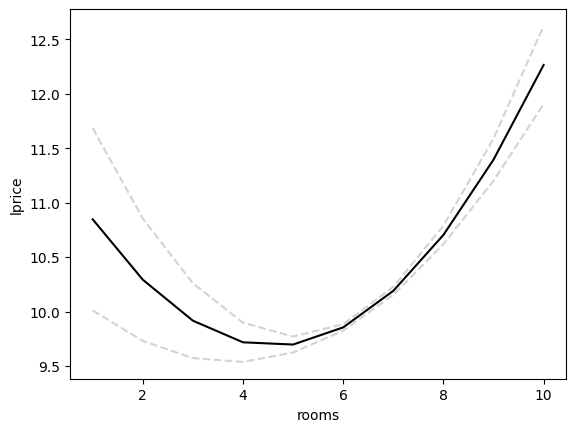

In [ ]:
dist_mean = np.mean(hprice2['dist'])

X = pd.DataFrame({'rooms': np.linspace(1, 10, num=10),
                  'dist': dist_mean})

lpr_PICI = results.get_prediction(X).summary_frame(alpha=0.05)
lpr_CI = lpr_PICI[['mean', 'mean_ci_lower', 'mean_ci_upper']]

# plot:
plt.plot(X['rooms'], lpr_CI['mean'], color='black',
         linestyle='-', label='')
plt.plot(X['rooms'], lpr_CI['mean_ci_upper'], color='lightgrey',
         linestyle='--', label='upper CI')
plt.plot(X['rooms'], lpr_CI['mean_ci_lower'], color='lightgrey',
         linestyle='--', label='lower CI')

plt.ylabel('lprice')
plt.xlabel('rooms')